## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

В начале остановимся на наиболее перспективных навыках

In [25]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

df_calls = pd.read_csv("/content/Calls.csv")
df_connection_time = pd.read_csv("/content/ConnectionTime.csv")
df_ed = pd.read_csv("/content/Education.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Рассмотрим датасет по ближе

In [3]:
df_calls.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


In [4]:
df_connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909


In [5]:
df_ed.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


In [7]:
df_train.head(3)

,id,type
0,ОРГ1-02050,2
1,ОРГ2-00621,1
2,ОРГ2-00992,1


In [8]:
df_test.head(3)

,id,type
0,ОРГ1-02649,0
1,ОРГ2-04011,0
2,ОРГ2-00081,0


Узнаем размерность наборов

In [9]:
print("df_train", df_train.shape)
print("df_calls", df_calls.shape)
print("df_connection_time", df_connection_time.shape)
print("df_ed", df_ed.shape)
print("df_test", df_test.shape)

df_train (1541, 2)
df_calls (304914, 6)
df_connection_time (172836, 8)
df_ed (5609, 4)
df_test (794, 2)


### Видоизмение данных

Обьединим два набора с данными

In [26]:
df_train = pd.merge(df_train, df_ed , on="id", how='left').drop_duplicates(subset="id")

df_train.head(3)

,id,type,Табельный номер руководителя,Вид образования,Специальность
0,ОРГ1-02050,2,NaN,Неполное высшее образование,Технологические машины и оборудование
2,ОРГ2-00621,1,NaN,NaN,NaN
3,ОРГ2-00992,1,ОРГ2-09100,Среднее профессиональное образование,Монтаж и эксплуатация оборудования и систем га...


In [27]:
df_train = df_train.drop(["Табельный номер руководителя", "Специальность"],axis = 1)

df_train["Вид образования"].value_counts()

Высшее образование                                351
Среднее профессиональное образование              256
Начальное профессиональное образование            162
Среднее общее образование                         141
Профессиональное обучение                          77
Высшее образование - бакалавриат                   67
Высшее образование - специалитет, магистратура     54
Среднее (полное) общее образование                 23
Неполное высшее образование                        10
Основное общее образование                          9
Повышение квалификации                              7
Переподготовка                                      2
Начальное общее образование                         1
Дополнительное профессиональное образование         1
Name: Вид образования, dtype: int64

In [28]:
df_train["Вид образования"] = df_train["Вид образования"].astype('category')
df_train["Вид образования"] = df_train["Вид образования"].cat.codes

df_train["Вид образования"].value_counts()

-1     380
 0     351
 13    256
 5     162
 12    141
 10     77
 1      67
 2      54
 11     23
 6      10
 7       9
 9       7
 8       2
 4       1
 3       1
Name: Вид образования, dtype: int64

Оставим только столбец - опоздания сотрудников

In [29]:
df_connection_time_res = df_connection_time[["id","Признак опоздания"]]
df_connection_time_res = df_connection_time_res[df_connection_time_res["Признак опоздания"].notna()]

df_connection_time_res.head()

,id,Признак опоздания
127561,ОРГ1-01589,Опоздание
127562,ОРГ1-01589,Опоздание
127563,ОРГ1-01589,Опоздание
127564,ОРГ1-01589,Опоздание
127565,ОРГ1-01589,Опоздание


In [30]:
df_connection_time_res = df_connection_time_res.groupby("id").count()
df_connection_time_res = df_connection_time_res.rename(columns={"Признак опоздания": "Число опозданий"})

df_connection_time_res.head(3)

,Число опозданий
id,
ОРГ1-00004,275
ОРГ1-00028,35
ОРГ1-00030,57


In [31]:
df_train = pd.merge(df_train, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

df_train.head(3)

,id,type,Вид образования,Число опозданий
0,ОРГ1-02050,2,6,5.0
1,ОРГ2-00621,1,-1,NaN
2,ОРГ2-00992,1,13,NaN


In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 0 to 1540
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1541 non-null   object 
 1   type             1541 non-null   int64  
 2   Вид образования  1541 non-null   int8   
 3   Число опозданий  1541 non-null   float64
dtypes: float64(1), int64(1), int8(1), object(1)
memory usage: 49.7+ KB


Заменим пропуски на нули

In [35]:
df_train = df_train.fillna(0)

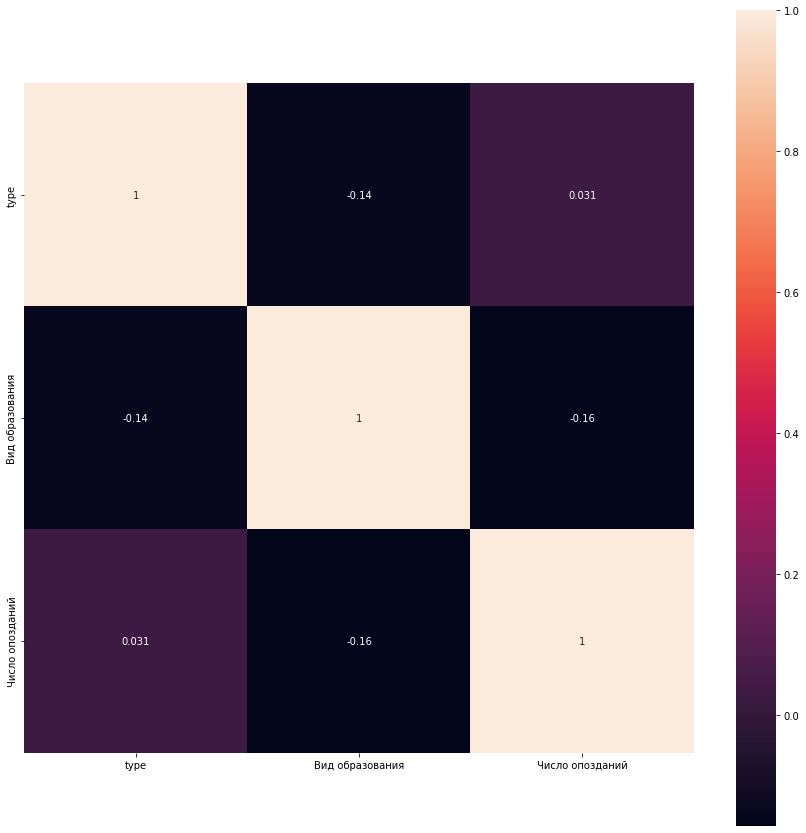

In [36]:
plt.rcParams['figure.figsize']=(15,15)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Выделим выборки

In [37]:
X = df_train.drop(["id", "type"], axis = 1)
y = df_train[["type"]]

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 0 to 1540
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Вид образования  1541 non-null   int8   
 1   Число опозданий  1541 non-null   float64
dtypes: float64(1), int8(1)
memory usage: 25.6 KB


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [40]:
clf = RandomForestClassifier(random_state=0)

In [41]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(random_state=0)

## Оценка точности

In [42]:
pred = clf.predict(X_test)

In [43]:
y_test.head(3)

,type
1491,2
1155,1
1252,2


In [44]:
from sklearn.metrics import recall_score

print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.33295424047235644
